## Лабораторная работа 5: Обучение и тестирование модели

In [96]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image


In [97]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms



создание списка путей изображений из заданного csv-файла

In [98]:
dframe = pd.read_csv(
    "D:\Lab on python\Lab_1_var_4\Lab2\csv_files\datasets.csv", delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list=dframe["Absolute path"].tolist()
random.shuffle(img_list)
print(img_list[:5])


['D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0153.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0907.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\rose\\0582.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0098.jpg', 'D:\\Lab on python\\Lab_1_var_4\\dataset\\tulip\\0977.jpg']


Способ получение метки класса

In [99]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['tulip', 'tulip', 'rose', 'tulip', 'tulip']


Разделение списка изображение на тренировочный, тестовый и валидационный (80:10:10)

In [100]:
train_list = img_list[0 : int(len(img_list) * 0.8)]
test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]
print(len(train_list ))
print(len(test_list))
print(len(val_list))



1608
201
202


Проверка картинок

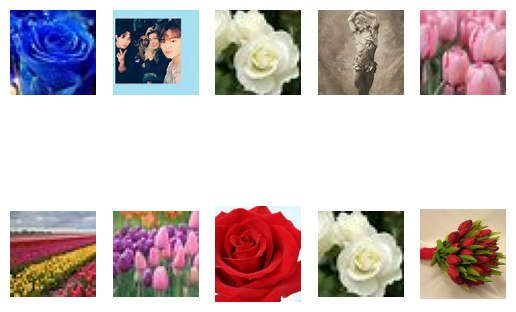

In [101]:
random_idx = np.random.randint(1,len(img_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

класс dataset, который будет хранить загруженные и преобразованные изображения и метки классов 0 - розы, 1 - тюльпаны

In [102]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_label=[]
        for i in range(len(self.file_list)):
            img_label.append(os.path.basename(os.path.dirname(self.file_list[i])))
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == 'rose':
            label=0
        elif label == 'tulip':
            label=1
        return img_transformed,label  

пайплайн предобработки данных и формированя набора даных, который будет участвовать в обучении

In [103]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(val_list, transform=fixed_transforms)

In [104]:
print(len(train_data))
train_data[0][0].shape


1608


torch.Size([3, 224, 224])

класс построения сверточной модели:
1. 3 слоя свертки и 2 полностью связанных слоя
2. пакетная нормализация для ограничения переобучения

In [105]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

функция для создания графиков

In [107]:
def show_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="orange", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="steelblue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="steelblue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 
    

цикл обучения

In [108]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)


9 запусков с разными batch_size и lear и графиками для тренировочной и валидационной выборки

Epoch : 1, train accuracy : 0.6908823251724243, train loss : 0.5521355867385864
Epoch : 1, val_accuracy : 0.8966666460037231, val_loss : 0.3805324137210846
Epoch : 2, train accuracy : 0.8632354140281677, train loss : 0.37575021386146545
Epoch : 2, val_accuracy : 0.7599999904632568, val_loss : 0.3771066665649414
Epoch : 3, train accuracy : 0.8814706206321716, train loss : 0.28697314858436584
Epoch : 3, val_accuracy : 0.9533333778381348, val_loss : 0.17060346901416779
Epoch : 4, train accuracy : 0.9147059321403503, train loss : 0.2305409163236618
Epoch : 4, val_accuracy : 0.9466667175292969, val_loss : 0.2020120769739151
Epoch : 5, train accuracy : 0.929705798625946, train loss : 0.20725400745868683
Epoch : 5, val_accuracy : 0.7900000214576721, val_loss : 0.2793194651603699
Epoch : 6, train accuracy : 0.9279411435127258, train loss : 0.1908598244190216
Epoch : 6, val_accuracy : 0.9700000286102295, val_loss : 0.10223135352134705
Epoch : 7, train accuracy : 0.923529326915741, train loss : 

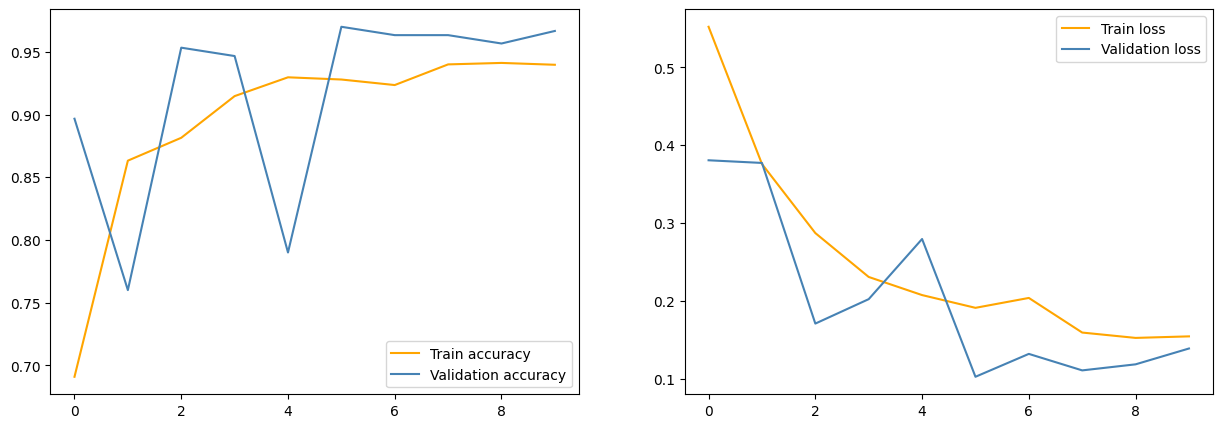

In [109]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9411110877990723, train loss : 0.15090225636959076
Epoch : 1, val_accuracy : 0.9850000143051147, val_loss : 0.06555794924497604
Epoch : 2, train accuracy : 0.9511110186576843, train loss : 0.13909676671028137
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.16460537910461426
Epoch : 3, train accuracy : 0.9194444417953491, train loss : 0.15906713902950287
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.0807081088423729
Epoch : 4, train accuracy : 0.9255555272102356, train loss : 0.1773001253604889
Epoch : 4, val_accuracy : 0.9774999618530273, val_loss : 0.06715308129787445
Epoch : 5, train accuracy : 0.9572222232818604, train loss : 0.13143287599086761
Epoch : 5, val_accuracy : 0.9824999570846558, val_loss : 0.06285373121500015
Epoch : 6, train accuracy : 0.9183332920074463, train loss : 0.24236446619033813
Epoch : 6, val_accuracy : 0.9824999570846558, val_loss : 0.06588804721832275
Epoch : 7, train accuracy : 0.9350000023841858, train 

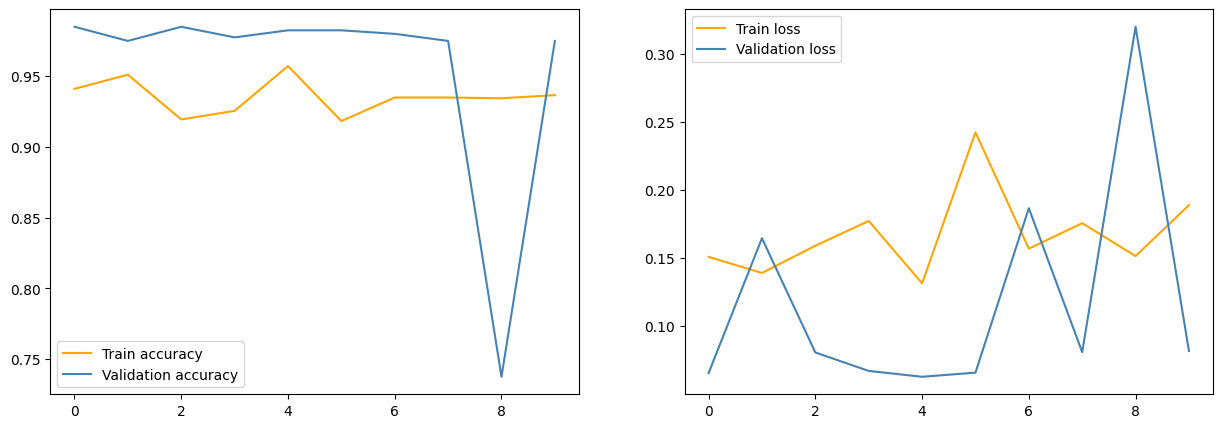

In [110]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9767901301383972, train loss : 0.05803467705845833
Epoch : 1, val_accuracy : 0.9653465151786804, val_loss : 0.10422878712415695
Epoch : 2, train accuracy : 0.9808024764060974, train loss : 0.05416630953550339
Epoch : 2, val_accuracy : 0.9504950642585754, val_loss : 0.09278660267591476
Epoch : 3, train accuracy : 0.9805555939674377, train loss : 0.04856302589178085
Epoch : 3, val_accuracy : 0.9554455280303955, val_loss : 0.09194108843803406
Epoch : 4, train accuracy : 0.9827778339385986, train loss : 0.044479478150606155
Epoch : 4, val_accuracy : 0.9752475023269653, val_loss : 0.07189025729894638
Epoch : 5, train accuracy : 0.9808024764060974, train loss : 0.05369102954864502
Epoch : 5, val_accuracy : 0.9504950642585754, val_loss : 0.10502740740776062
Epoch : 6, train accuracy : 0.9817901253700256, train loss : 0.04519256204366684
Epoch : 6, val_accuracy : 0.9702970385551453, val_loss : 0.08818084746599197
Epoch : 7, train accuracy : 0.9809259176254272, tra

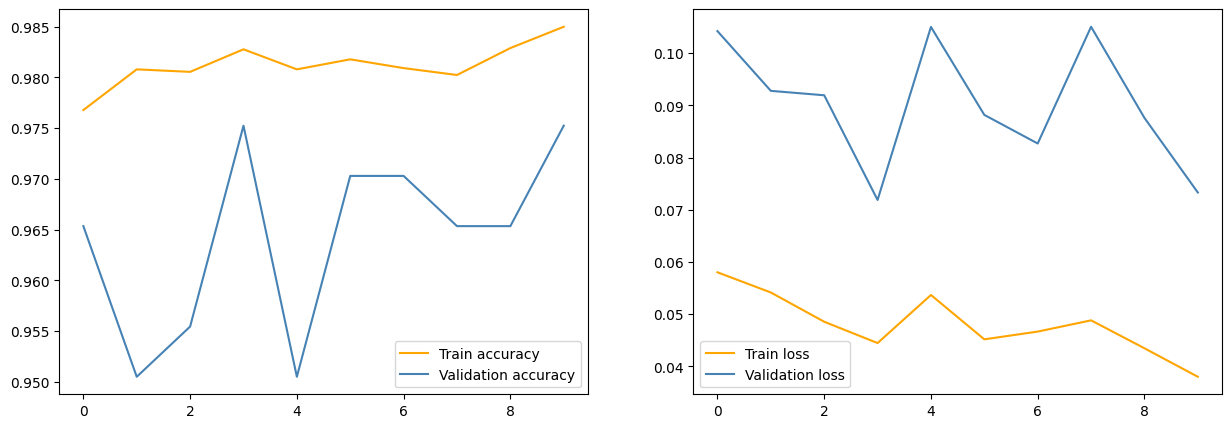

In [119]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.867647111415863, train loss : 0.3837087154388428
Epoch : 1, val_accuracy : 0.9566667079925537, val_loss : 0.14188066124916077
Epoch : 2, train accuracy : 0.9014706015586853, train loss : 0.27115583419799805
Epoch : 2, val_accuracy : 0.9533333778381348, val_loss : 0.19559061527252197
Epoch : 3, train accuracy : 0.9049999117851257, train loss : 0.2352149337530136
Epoch : 3, val_accuracy : 0.9533333778381348, val_loss : 0.1300823837518692
Epoch : 4, train accuracy : 0.9288234114646912, train loss : 0.2083035111427307
Epoch : 4, val_accuracy : 0.9566667079925537, val_loss : 0.1237417608499527
Epoch : 5, train accuracy : 0.9108823537826538, train loss : 0.2382025122642517
Epoch : 5, val_accuracy : 0.7900000214576721, val_loss : 0.24316301941871643
Epoch : 6, train accuracy : 0.9205881953239441, train loss : 0.19473502039909363
Epoch : 6, val_accuracy : 0.9600000381469727, val_loss : 0.11401696503162384
Epoch : 7, train accuracy : 0.9411763548851013, train loss 

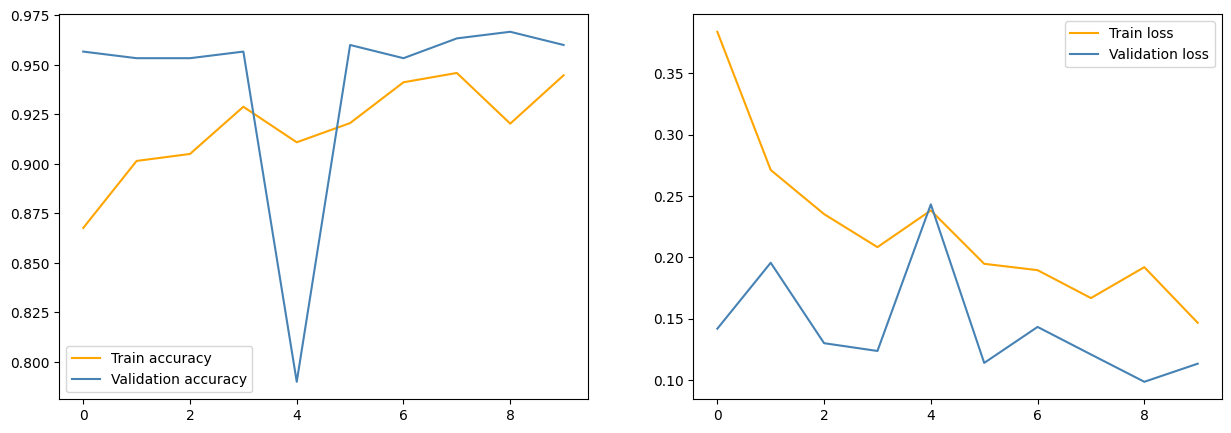

In [112]:
train_loop(10, 100, 0.005)

Epoch : 1, train accuracy : 0.9388888478279114, train loss : 0.16409742832183838
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.2053479701280594
Epoch : 2, train accuracy : 0.9394444227218628, train loss : 0.1722421944141388
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.08834578841924667
Epoch : 3, train accuracy : 0.9361110925674438, train loss : 0.14602580666542053
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.16081318259239197
Epoch : 4, train accuracy : 0.925000011920929, train loss : 0.18832750618457794
Epoch : 4, val_accuracy : 0.9650000333786011, val_loss : 0.09587365388870239
Epoch : 5, train accuracy : 0.9494444727897644, train loss : 0.13480213284492493
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.06883595883846283
Epoch : 6, train accuracy : 0.9622222185134888, train loss : 0.10500164330005646
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.0720888152718544
Epoch : 7, train accuracy : 0.9427777528762817, train lo

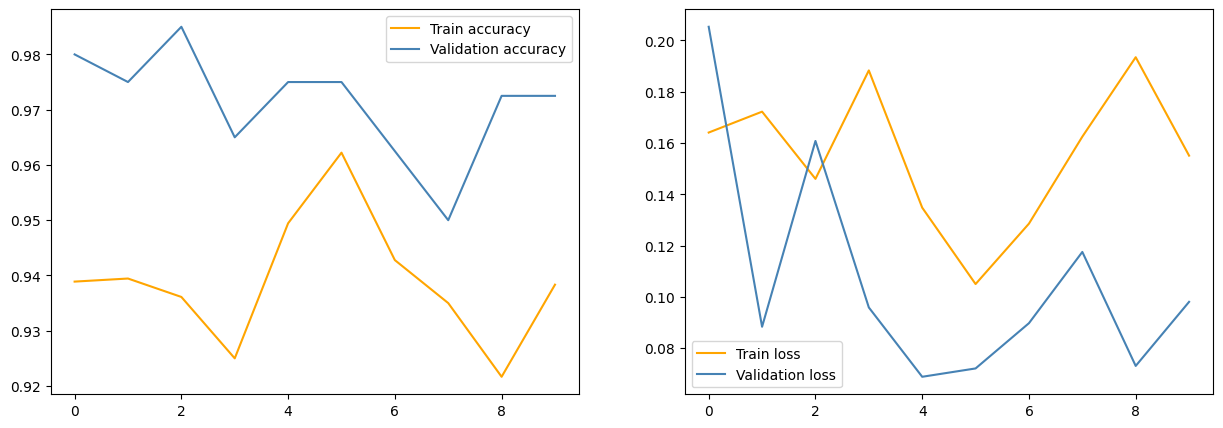

In [113]:
train_loop(10, 200, 0.005)

Epoch : 1, train accuracy : 0.9477161169052124, train loss : 0.13700804114341736
Epoch : 1, val_accuracy : 0.9554455280303955, val_loss : 0.1165052279829979
Epoch : 2, train accuracy : 0.9522839784622192, train loss : 0.1193910464644432
Epoch : 2, val_accuracy : 0.9603960514068604, val_loss : 0.09905557334423065
Epoch : 3, train accuracy : 0.9587036967277527, train loss : 0.10804799944162369
Epoch : 3, val_accuracy : 0.9554455280303955, val_loss : 0.09738727658987045
Epoch : 4, train accuracy : 0.9651234149932861, train loss : 0.08950341492891312
Epoch : 4, val_accuracy : 0.9702970385551453, val_loss : 0.0956292673945427
Epoch : 5, train accuracy : 0.9639505743980408, train loss : 0.09157349914312363
Epoch : 5, val_accuracy : 0.9356435537338257, val_loss : 0.11652945727109909
Epoch : 6, train accuracy : 0.9662346243858337, train loss : 0.08975880593061447
Epoch : 6, val_accuracy : 0.9603960514068604, val_loss : 0.07627091556787491
Epoch : 7, train accuracy : 0.9687036871910095, train l

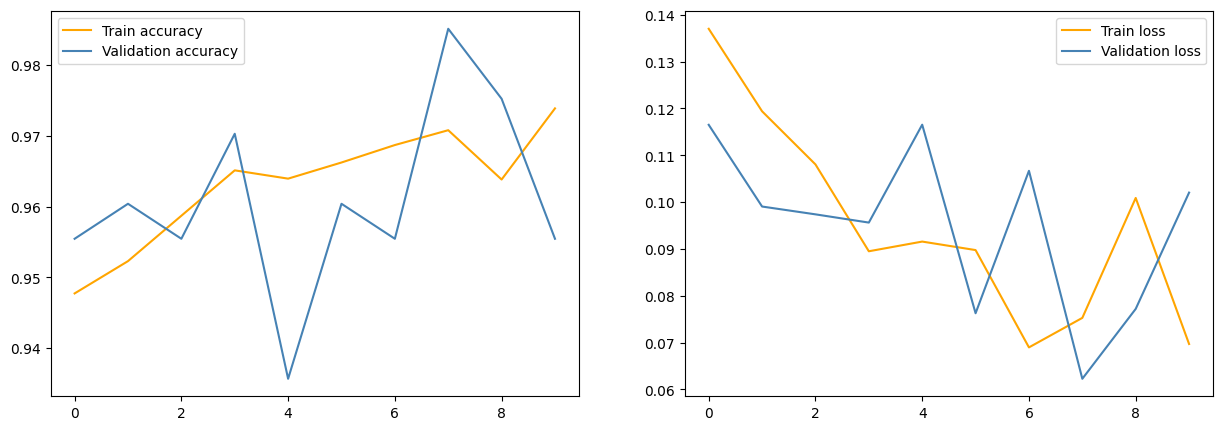

In [114]:
train_loop(10, 300, 0.005)

Epoch : 1, train accuracy : 0.9288234710693359, train loss : 0.19144727289676666
Epoch : 1, val_accuracy : 0.9666666984558105, val_loss : 0.11759162694215775
Epoch : 2, train accuracy : 0.9361764788627625, train loss : 0.16840574145317078
Epoch : 2, val_accuracy : 0.9600000381469727, val_loss : 0.10536308586597443
Epoch : 3, train accuracy : 0.9552940130233765, train loss : 0.13483236730098724
Epoch : 3, val_accuracy : 0.9733333587646484, val_loss : 0.08348394185304642
Epoch : 4, train accuracy : 0.9579411149024963, train loss : 0.11098112910985947
Epoch : 4, val_accuracy : 0.9766666889190674, val_loss : 0.07275621592998505
Epoch : 5, train accuracy : 0.9247057437896729, train loss : 0.17243212461471558
Epoch : 5, val_accuracy : 0.9733333587646484, val_loss : 0.08690627664327621
Epoch : 6, train accuracy : 0.9391176104545593, train loss : 0.13405729830265045
Epoch : 6, val_accuracy : 0.9700000286102295, val_loss : 0.11732205748558044
Epoch : 7, train accuracy : 0.9355881214141846, trai

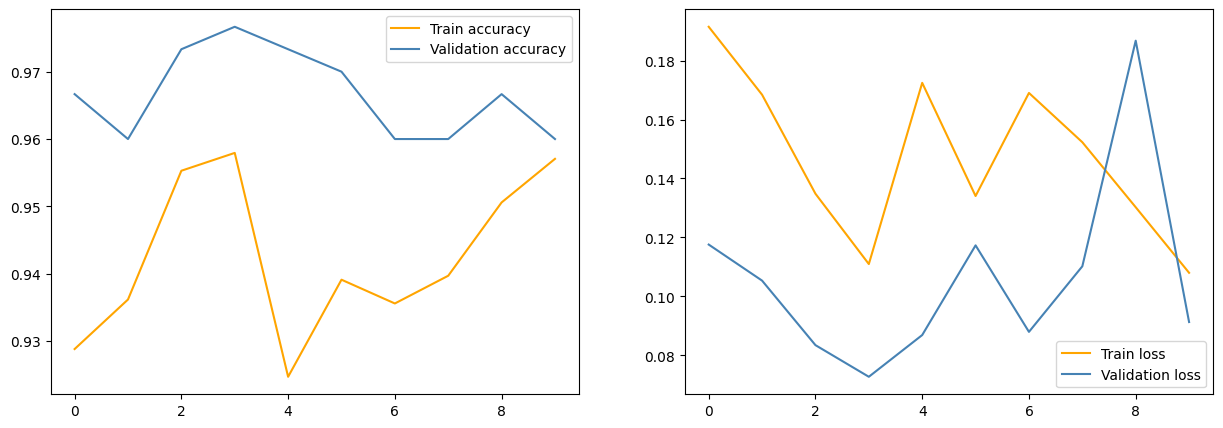

In [115]:
train_loop(10, 100, 0.007)

Epoch : 1, train accuracy : 0.9444444179534912, train loss : 0.15220317244529724
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.050463031977415085
Epoch : 2, train accuracy : 0.9505555629730225, train loss : 0.11119846254587173
Epoch : 2, val_accuracy : 0.7274999618530273, val_loss : 0.7364577651023865
Epoch : 3, train accuracy : 0.9599999189376831, train loss : 0.12319168448448181
Epoch : 3, val_accuracy : 0.9750000238418579, val_loss : 0.08488254994153976
Epoch : 4, train accuracy : 0.9616667032241821, train loss : 0.1093483716249466
Epoch : 4, val_accuracy : 0.9700000286102295, val_loss : 0.07771611958742142
Epoch : 5, train accuracy : 0.9411110877990723, train loss : 0.1484423577785492
Epoch : 5, val_accuracy : 0.9824999570846558, val_loss : 0.05796698108315468
Epoch : 6, train accuracy : 0.9411110877990723, train loss : 0.12752214074134827
Epoch : 6, val_accuracy : 0.9774999618530273, val_loss : 0.07917547225952148
Epoch : 7, train accuracy : 0.9150000810623169, train 

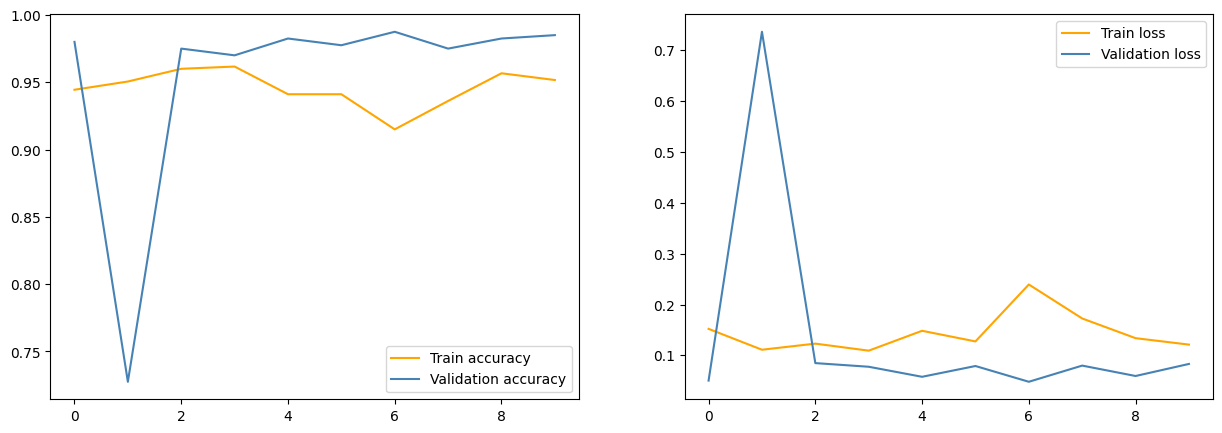

In [116]:
train_loop(10, 200, 0.007)

Epoch : 1, train accuracy : 0.9586419463157654, train loss : 0.09894701093435287
Epoch : 1, val_accuracy : 0.9653465151786804, val_loss : 0.1101761907339096
Epoch : 2, train accuracy : 0.9688271880149841, train loss : 0.10060576349496841
Epoch : 2, val_accuracy : 0.9653465151786804, val_loss : 0.09803128987550735
Epoch : 3, train accuracy : 0.9723456501960754, train loss : 0.07861513644456863
Epoch : 3, val_accuracy : 0.9554455280303955, val_loss : 0.11557145416736603
Epoch : 4, train accuracy : 0.9666049480438232, train loss : 0.0982653945684433
Epoch : 4, val_accuracy : 0.9702970385551453, val_loss : 0.11240711808204651
Epoch : 5, train accuracy : 0.9703702926635742, train loss : 0.07979325205087662
Epoch : 5, val_accuracy : 0.9752475023269653, val_loss : 0.0606299564242363
Epoch : 6, train accuracy : 0.9650617837905884, train loss : 0.08818000555038452
Epoch : 6, val_accuracy : 0.9504950642585754, val_loss : 0.09783557057380676
Epoch : 7, train accuracy : 0.9669753313064575, train l

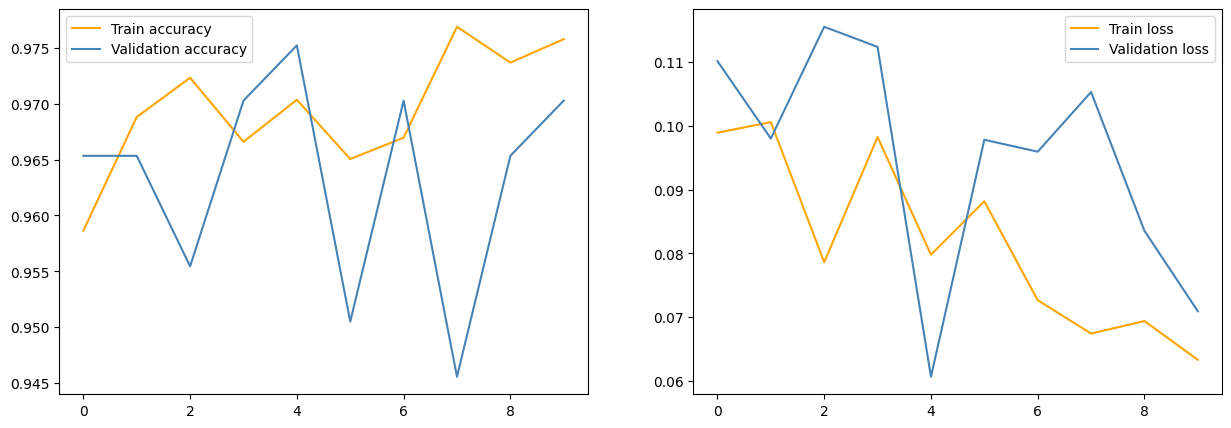

In [118]:
train_loop(10, 300, 0.007)

Создание csv-файл с полученными результатами

In [120]:
rose_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size=100, 
                                          shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))
rose_probs.sort(key = lambda x : int(x[0]))
rose_probs[:10]

[(tensor(0), 1.3735360880673397e-05),
 (tensor(0), 6.84471451677382e-05),
 (tensor(0), 0.00026181910652667284),
 (tensor(0), 1.226516815222567e-05),
 (tensor(0), 0.009806937538087368),
 (tensor(0), 1.833458554756362e-05),
 (tensor(0), 0.5604604482650757),
 (tensor(0), 0.001296983566135168),
 (tensor(0), 0.012398500926792622),
 (tensor(0), 6.999768083915114e-05)]

In [121]:
idx = list(i for i in range(len(rose_probs)))
prob = list(map(lambda x: x[1],rose_probs))

In [125]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.000014
1,1,0.000068
2,2,0.000262
3,3,0.000012
4,4,0.009807
...,...,...
196,196,0.611358
197,197,0.998926
198,198,0.999577
199,199,0.999300


сохранение модели

In [126]:
torch.save(model.state_dict(), os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt"))

повторная инициализация модели

In [127]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("D:\Lab on python\Lab_1_var_4\Lab5", "weight.pt")))

<All keys matched successfully>

Запуск модели на тренировочных данных

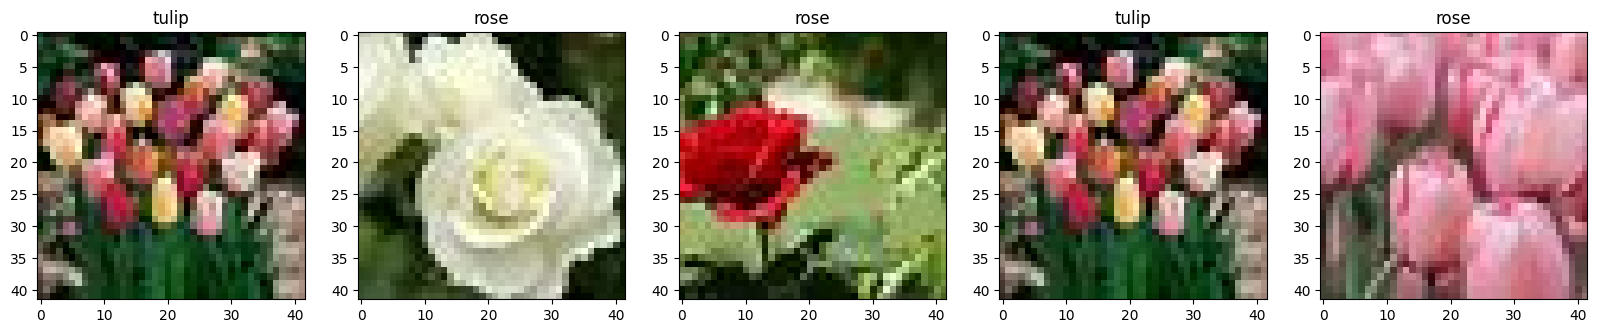

In [171]:
id_list = []
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)